In [204]:
import os

from scipy.stats import ttest_ind
from sklearn.neighbors import NearestNeighbors
import anndata
import matplotlib.pyplot as plt
import numpy as np
import pyometiff
import pandas as pd
import seaborn as sns

In [220]:
PATH_TO_FOLDER = os.path.join('..', 'd4l')
TRAIN_DATA_PATH = os.path.join(PATH_TO_FOLDER, 'train')

if PATH_TO_FOLDER is None:
    raise ValueError('Please set PATH_TO_FOLDER to a path with unzipped training data.')

ANNDATA_PATH = 'cell_data.h5ad'
TRAIN_ANNDATA_PATH = os.path.join(TRAIN_DATA_PATH, ANNDATA_PATH)
PLOTS_DIR = 'plots'

In [218]:
def normalize(expressions: pd.DataFrame, scaling_factor:int = 5):
    """
    Transform in CELESTA.ipynb
    
    Normalizes expression data using the arcsinh transformation.
    """
    expressions_transformed = np.arcsinh(expressions) / scaling_factor
    return expressions_transformed

def plot_marker_expressions(exp_df: pd.DataFrame, markers: list, plot_path: str):
    """
    Plot the expression values of marker genes.
    """
    fig, axs = plt.subplots(len(markers), 1, figsize=(7, 5 * len(markers)))
    for i, gene in enumerate(markers):
        axs[i].hist(exp_df[gene], bins=100, color='r', alpha=0.5)
        axs[i].set_title(f'{gene}')
    plt.savefig(plot_path)

def plot_cell_type_count(exp_df: pd.DataFrame, plot_path: str):
    fig, ax = plt.subplots(1, 1, figsize=(13, 5))
    ax.hist(exp_df['celltypes'], bins=30, color='r', alpha=0.5)
    ax.set_title('Cell Type Count')
    plt.savefig(plot_path)

def plot_marker_expression_range(exp_df: pd.DataFrame, markers: list, plot_path: str):
    """
    Plot the range of expression values for each marker gene. Scatter plot of the minimum and maximum expression values.
    """
    fig, axs = plt.subplots(len(markers), 1, figsize=(15, 5 * len(markers)))
    for i, marker in enumerate(markers):
        axs[i].scatter(exp_df['celltypes'], exp_df[marker], color='g', alpha=0.1)
        axs[i].set_title(f'{marker} - Expression Range')
    plt.savefig(plot_path)

def plot_variance_of_markers(exp_df: pd.DataFrame, plot_path: str):
    """
    Plot the variance of each marker gene.
    """
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.bar(exp_df.columns, exp_df.var(), color='b', alpha=0.5)
    ax.set_title('Variance of Marker Genes')
    ax.set_xticklabels(exp_df.columns, rotation=90)
    plt.savefig(plot_path)

def analyze_marker_expressions(exp_df: pd.DataFrame, all_data_df: pd.DataFrame, p_value_threshold: float = 0.01):
    cell_types = all_data_df['celltypes'].unique()
    markers = exp_df.columns
    result = {}
    subjects = all_data_df['sample_id'].unique()
    

    for cell_type in cell_types:
        lower_markers = []
        higher_markers = []
        for subject in subjects:
            lower = set()
            higher = set()
            subject_df = all_data_df[all_data_df['sample_id'] == subject]
            for marker in markers:
                cell_type_expr = subject_df[subject_df['celltypes'] == cell_type][marker]
                other_cell_types_expr = subject_df[subject_df['celltypes'] != cell_type][marker]

                t_stat, p_value = ttest_ind(cell_type_expr, other_cell_types_expr, equal_var=False)
                if p_value < p_value_threshold:
                    if cell_type_expr.mean() < other_cell_types_expr.mean():
                        lower.add(marker)
                    else:
                        higher.add(marker)
            lower_markers.append(lower)
            higher_markers.append(higher)
        result[cell_type] = {'lower': lower_markers, 'higher': higher_markers}

    return result

def get_significant_markers(marker_dict: dict, all_data_df: pd.DataFrame, threshold: float = 0.8):
    """
    Get the markers that are present in cell types in at least 80% of subjects.
    """
    num_of_subjects = len(all_data_df['sample_id'].unique())
    result_dict = {}
    for cell_type, markers_sets in marker_dict.items():
        result_dict[cell_type] = {'lower' : [], 'higher' : []}
        for markers_set in markers_sets['lower']:
            result_dict[cell_type]['lower'] += markers_set
        for markers_set in markers_sets['higher']:
            result_dict[cell_type]['higher'] += markers_set

        result_dict[cell_type]['lower'] = [marker for marker in set(result_dict[cell_type]['lower']) if result_dict[cell_type]['lower'].count(marker) / num_of_subjects >= threshold]
        result_dict[cell_type]['higher'] = [marker for marker in set(result_dict[cell_type]['higher']) if result_dict[cell_type]['higher'].count(marker) / num_of_subjects >= threshold]
    return result_dict
        
def make_table_with_significant_markers(significant_markers_dict: dict):
    all_markers = set()
    
    cell_types = significant_markers_dict.keys()
    for cell_type, markers_dict in significant_markers_dict.items():
        all_markers.update(markers_dict['lower'])
        all_markers.update(markers_dict['higher'])
    marker_to_level_dict = {marker: [] for marker in all_markers}
    for cell_type, markers_dict in significant_markers_dict.items():
        for marker in all_markers:
            if marker in markers_dict['lower']:
                marker_to_level_dict[marker].append('lower')
            elif marker in markers_dict['higher']:
                marker_to_level_dict[marker].append('higher')
            else:
                marker_to_level_dict[marker].append('none')        
    
    result_df = pd.DataFrame(marker_to_level_dict)
    result_df['celltype'] = cell_types
    result_df.set_index('celltype', inplace=True)

    return result_df

def get_neighbors_cell_types(all_data_df: pd.DataFrame, cells_indices: list):
    return all_data_df.loc[cells_indices]['celltypes'].values

def get_knn_of_cell_types(all_data_df, k=5):
    """
    Get the k nearest neighbors of each cell based on the x and y coordinates.
    """
    rois = all_data_df['sample_id'].unique()
    indices_all = []
    neighbors = []
    for roi in rois:
        roi_df = all_data_df[all_data_df['sample_id'] == roi]
        nn = NearestNeighbors(n_neighbors=k, metric='euclidean')
        data = roi_df[['Pos_X', 'Pos_Y']]
        nn.fit(data)
        distances, indices = nn.kneighbors(data)
        indices_all += list(roi_df.index)
        neighbors += indices.tolist()
    
    all_data_df['knn'] = neighbors

    all_data_df['knn_celltypes'] = all_data_df['knn'].apply(lambda x: get_neighbors_cell_types(all_data_df, x))
    return indices_all, neighbors, all_data_df

def get_neighbors_cell_types_distribution(all_data_df: pd.DataFrame, plot_path: str):
    cell_types = all_data_df['celltypes'].unique()
    result = {}
    for cell_type in cell_types:
        subdf = all_data_df[all_data_df['celltypes'] == cell_type]
        neighbors = subdf['knn_celltypes'].values
        neighbors = [item for sublist in neighbors for item in sublist]
        result[cell_type] = {neighbor: neighbors.count(neighbor)/len(neighbors) for neighbor in set(neighbors)}

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.heatmap(pd.DataFrame(result), cmap='coolwarm', annot=True, fmt=".2f")
    plt.savefig(plot_path)
    return result



In [96]:
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)

In [97]:
markers = train_anndata.var['marker']
expressions_df = pd.DataFrame(train_anndata.layers["exprs"], columns=markers)
all_data = pd.concat([train_anndata.obs.reset_index(), expressions_df], axis=1)

# General data overview

In [98]:
print("There is a total of", len(all_data), "cells in the dataset.")

There is a total of 236791 cells in the dataset.


In [99]:
print("Minimal expression value: ", np.min(expressions_df.values))
print("Maximal expression value: ", np.max(expressions_df.values))
print("Mean expression value: ", np.mean(expressions_df.values))
print("Median expression value: ", np.median(expressions_df.values))
print("Maximal standard deviation of expression values: ", np.max(np.std(expressions_df.values, axis=0)))
print("Minimal standard deviation of expression values: ", np.min(np.std(expressions_df.values, axis=0)))

Minimal expression value:  0.0
Maximal expression value:  8.436070526198012
Mean expression value:  1.347737665027196
Median expression value:  0.914181447627153
Maximal standard deviation of expression values:  1.4945013816311672
Minimal standard deviation of expression values:  0.28289971656300267


There are only non-negative marker expression values.

The 'distToCells' column is the only one containing NaN values, with a total of 11829 NaN entries.

In [100]:
all_data['distToCells'].isnull().sum()

11829

The dataset provided includes spatial information at the individual cell level. It includes X and Y coordinates, along with marker levels acquired through the IMC method, as well as cell types.

In [199]:
print(f"Dataset has {len(all_data['image'].unique())} tissue images from {len(all_data['sample_id'].unique())} unique subjects.")
print(f"Dataset has {len(all_data['BatchId'].unique())} batches.")
print(f"Dataset has {len(all_data['celltypes'].unique())} unique cell types:", ", ".join(list(all_data['celltypes'].unique())))
print(f"Each cell has {len(expressions_df.columns)} features (marker expressions):", ", ".join(list(expressions_df.columns)))

Dataset has 125 tissue images from 125 unique subjects.
Dataset has 16 batches.
Dataset has 15 unique cell types: MacCD163, Mural, DC, Tumor, CD4, HLADR, NK, CD8, Treg, Neutrophil, plasma, undefined, B, pDC, BnT
Each cell has 40 features (marker expressions): MPO, HistoneH3, SMA, CD16, CD38, HLADR, CD27, CD15, CD45RA, CD163, B2M, CD20, CD68, Ido1, CD3, LAG3, CD11c, PD1, PDGFRb, CD7, GrzB, PDL1, TCF7, CD45RO, FOXP3, ICOS, CD8a, CarbonicAnhydrase, CD33, Ki67, VISTA, CD40, CD4, CD14, Ecad, CD303, CD206, cleavedPARP, DNA1, DNA2



Below we present distribution of normalized data for a couple of markers.

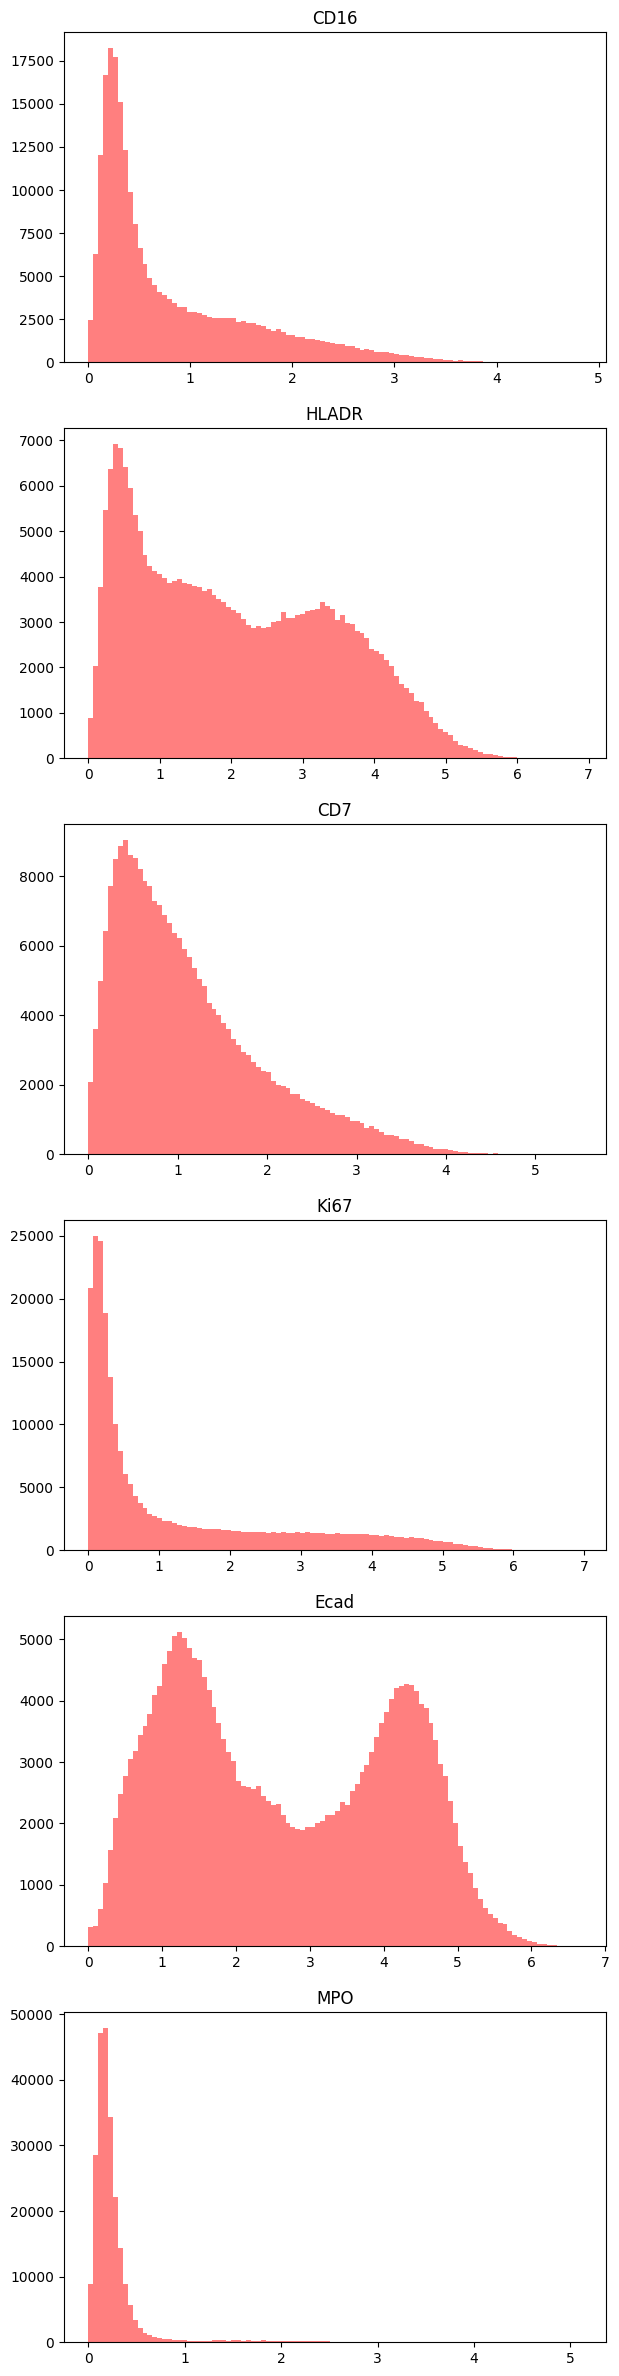

In [221]:
plot_marker_expressions(expressions_df, ['CD16', 'HLADR', 'CD7', 'Ki67', 'Ecad','MPO'], os.path.join(PLOTS_DIR, 'example_markers_expressions_histograms.png'))

Some markers display a bimodal distribution, featuring two distinct expression peaks. Others showcase a unimodal distribution with a narrower range of expression values across all cells, or a prominent single peak with the remaining values appearing relatively uniform. Additionally, some markers exhibit a somewhat normal distribution but may be skewed.

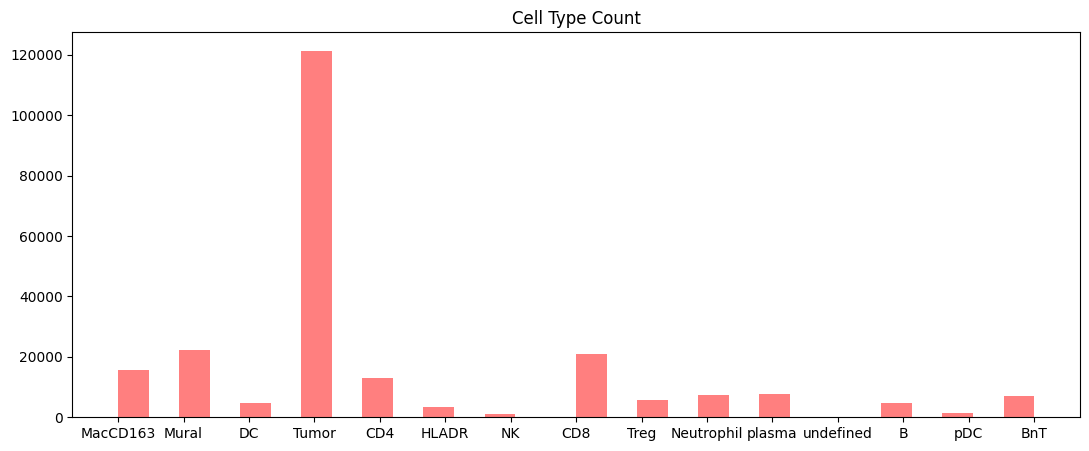

In [208]:
plot_cell_type_count(all_data, os.path.join(PLOTS_DIR, 'cell_types_count.png'))

As presented, there is a very significant prevalence of Tumor cells.

Markers exhibit varying levels across different cell types, and we illustrate these discrepancies for a selection of markers.

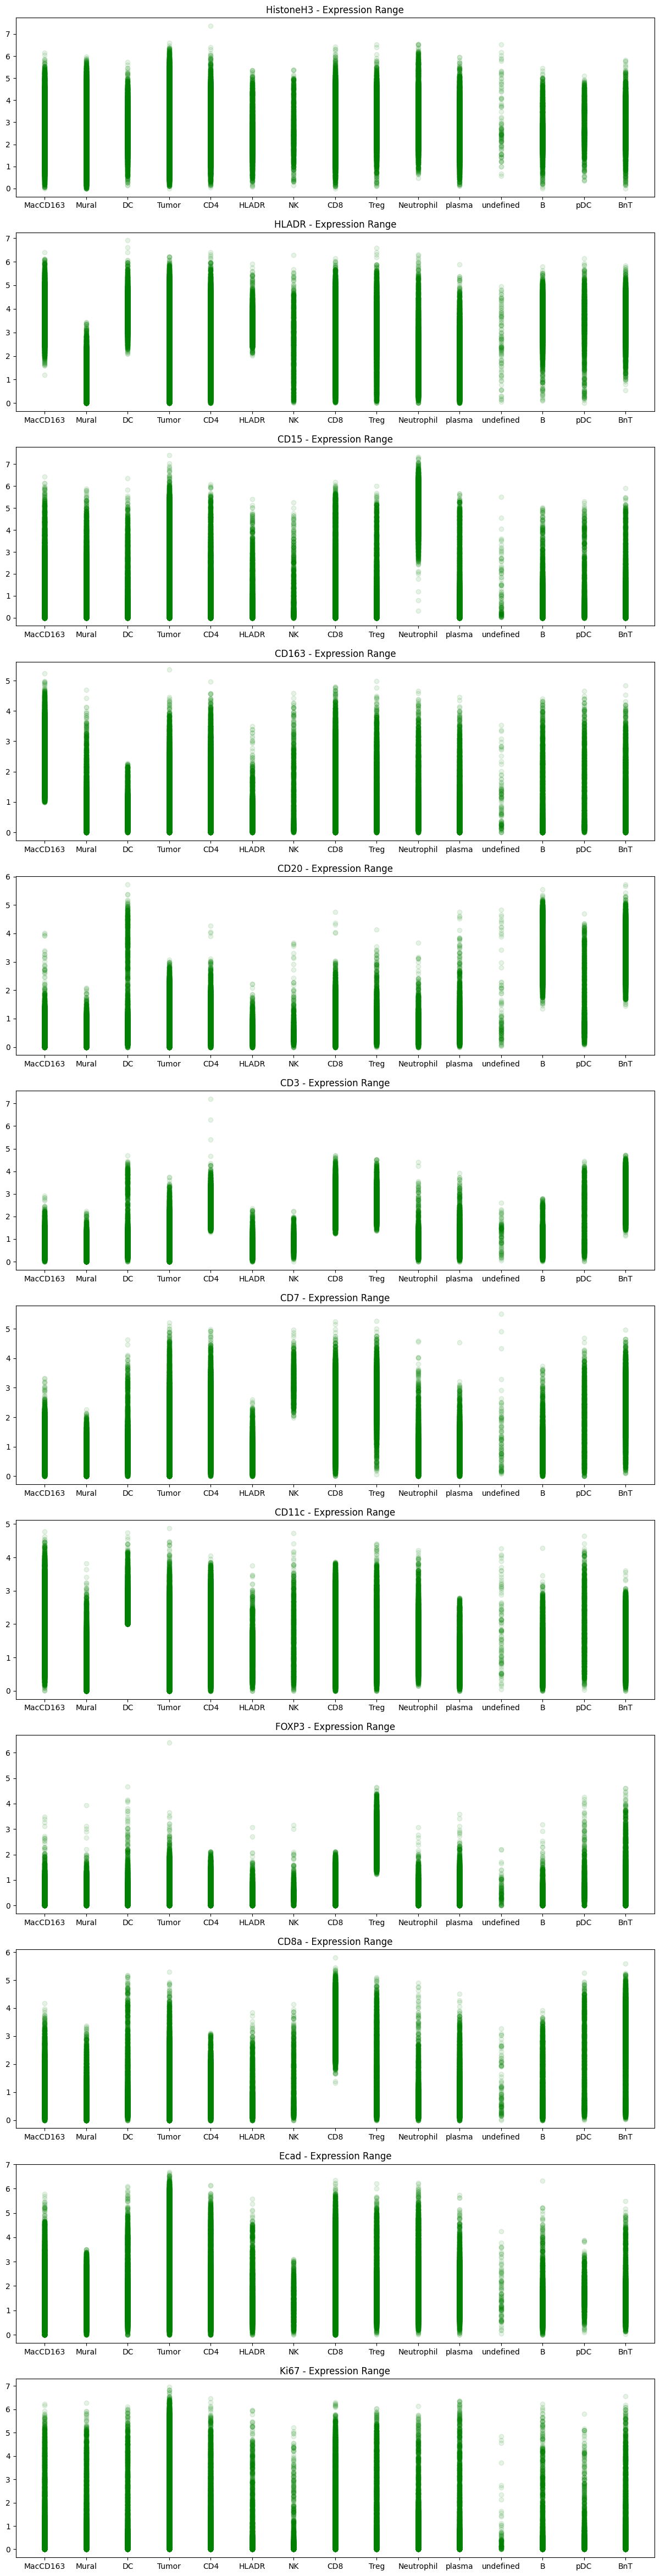

In [212]:
plot_marker_expression_range(all_data,
							['HistoneH3', 'HLADR', 'CD15', 'CD163', 'CD20', 'CD3', 'CD7', 'CD11c', 'FOXP3', 'CD8a', 'Ecad', 'Ki67'],
							os.path.join(PLOTS_DIR, 'marker_expression_ranges.png'))

/tmp/ipykernel_4356/1638940810.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(exp_df.columns, rotation=90)


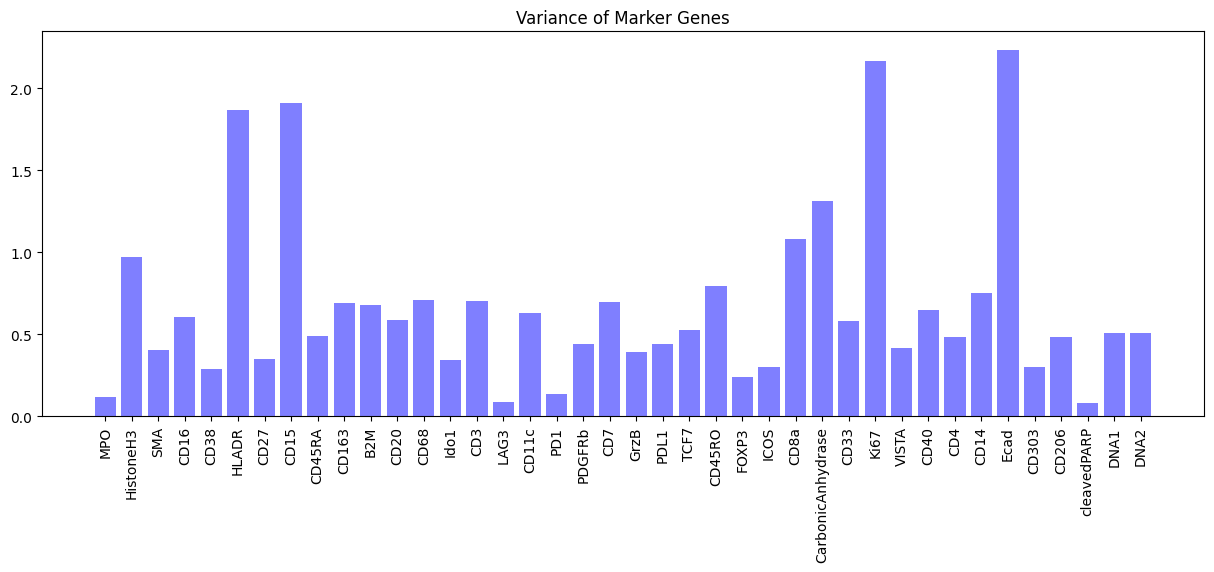

In [213]:
plot_variance_of_markers(expressions_df, os.path.join(PLOTS_DIR, 'markers_variance.png'))

## Cell types and markers correlation

Our objective was to examine the markers exhibiting significantly higher or lower levels across all cell types. To achieve this, we conducted T-tests comparing the means of marker levels for a specific cell type against the means of marker levels for the remaining cell types. Additionally, T-tests were performed for each Region of Interest (ROI) individually to ensure that any differences in marker level distributions were not confounded by potential batch effects.

We set the significance threshold at a p-value of 0.01 and identified sets of markers that were significantly higher or lower for each ROI and each cell type. We considered the results reliable if a particular marker showed a significant difference in at least 80% of the ROI.

The results are documented in the MARKERS_RELATIVE_LEVELS_DF_FILE file, and we highlight a selection of biologically intriguing findings below.

In [111]:
marker_expressions_levels = analyze_marker_expressions(expressions_df, all_data, p_value_threshold=0.01)

/home/rmalinowska/Documents/dl_project_venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/rmalinowska/Documents/dl_project_venv/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [112]:
significant_markers = get_significant_markers(marker_expressions_levels, all_data, threshold=0.8)

In [113]:
markers_signature_df = make_table_with_significant_markers(significant_markers)

In [115]:
MARKERS_RELATIVE_LEVELS_DF_FILE = 'markers_levels_in_cell_types_p01_diffvar.csv'
markers_signature_df.to_csv(MARKERS_RELATIVE_LEVELS_DF_FILE)
markers_signature_df = pd.read_csv(MARKERS_RELATIVE_LEVELS_DF_FILE)
markers_signature_df.set_index('celltype', inplace=True)

In [121]:
cell_types_subset = ['Tumor', 'Mural', 'DC', 'MacCD163', 'CD4', 'CD8', 'Treg']
markers_subset = ['HLADR', 'CD8a', 'CD11c', 'CD4', 'PDGFRb', 'Ecad', 'CD3', 'ICOS', 'FOXP3', 'SMA', 'CarbonicAnhydrase']
sub_signature_df = markers_signature_df.loc[cell_types_subset, markers_subset]

In [122]:
sub_signature_df

,HLADR,CD8a,CD11c,CD4,PDGFRb,Ecad,CD3,ICOS,FOXP3,SMA,CarbonicAnhydrase
celltype,,,,,,,,,,,
Tumor,none,none,none,none,lower,higher,lower,none,none,lower,higher
Mural,lower,lower,lower,lower,higher,lower,lower,lower,lower,higher,lower
DC,none,none,none,none,none,none,none,none,none,none,none
MacCD163,higher,none,higher,higher,none,lower,none,none,none,none,none
CD4,none,none,none,higher,none,none,higher,none,none,none,none
CD8,none,higher,none,none,none,none,higher,none,none,none,none
Treg,none,none,none,higher,none,none,higher,none,higher,none,none


Let us look at a subset of our findings that provide interesting biological interpretations:

## Biological explanation
* High expression of E-cad on Tumor cells

E-cad is a cell adhesion molecule that is commonly observed in epithelial cancers. It plays key role in maintaining tissue integrity and cell-cell adhesion. When tumor cells lose E-cad, they gain the ability to break away from the primary tumor mass and migrate to distant sites through metastasis. Given that in our data we observe high expression of E-cad on tumor cells, we can infere that studied tumors are not in the metastasis phase which might result in a better prognosis for the subjects.

* High expression of HLA-DR on Macrophages

HLA-DR is an MHC class II cel surface receptor and is presented on the surface of antigen-presenting cells like macrophages. This receptor plays crucial role in the immune response by presenting antigens to T cells, therby initiating and coordinating the body's defense against pathogens.

* High expression of CD11c on Macrophages and Dendritic cells

CD11c is a marker typically associated with dendritic cells and macrophages, which are crucial for antigen presetnation. Higher expression supports their key function in initiating and modulating immune responses by presenting antigens to T cells.

* High expression of CD4 in CD4 T cells

CD4 is a co-receptor that assists the T-cell receptor in communicating with an antigen-presenting cell. The higher expression of CD4 in CD4 T cells is fundamental for their role in the immune system, helping these cells to initiate a stronger immune reponse upon recogininzg antigens.

* Low expression of ICOS in Mural cells

ICOS is a protein expressed on activated T-cells and is cucia for their proliferation and survival. Mural cells do not tipically engage in direct immune responses or interactions that require T-cell co-stimulation, which aligns with their primary role in structural and vascular support rather than immune activation.

* High expression of SMA in Mural cells

SMA (smooth muscle actin) is a protein found in smooth muscle cells, including vascular smooth muscle cells, which are a type of a mural cell.

* High expression of CD8a on CD8 T cells

CD8 T cells also known ad cytotoxic T cells are a type of lyphocyte that plays a crucial role in the adaptive immune response. There are names after a surface protein called CD8, which serves as a marker for identifying and characterizing these cells, which justifies the high expression level.

* High expression of CD3 on T cells

CD3 ia a complex of proteins found on the surface of T cells. CD3 plays a povital role in T cell activation. In clinical settings, CD3 is used as a diagnostic marker to assess T cell populations. 

* High expression of Carbonic Anhydrase in Tumor cells

Carbonic anhydrases are a family of enzymes that catalyze reversible hydration of CO2 to HCO3- and H+ ions. Tumors often create an acidic microenvironment due to increased glycolysis and poor vascularization which leads to hypoxia and lactate accumulation. High expression helps tumor cells to adapt and might be linked to tumor progression including metastatis and angiogenesis which may forecast difficulty in the treatment.

* High expression of FOXP3 on Tregs

FOXP3 is primarily expressed in a specific subset of T cells called regulatory T cells (Tregs). Tregs are essential for suppressing excessive immune responses and maintaining immune homeostasis by preventing the immune system from attacking the body's own tissues (autoimmunity) and dampening immune responses to harmless environmental antigens. In the context of cancer, FOXP3+ Tregs can infiltrate the tumor microenvironment and suppress anti-tumor immune responses, thereby promoting tumor immune evasion and progression. The presence of FOXP3+ Tregs within tumors has been associated with poor prognosis in various cancer types. 



## Co-expression of markers
Analyzing co-expression involves studying how the levels of different markers relate to each other within a system. This is typically done by calculating correlation coefficients between pairs of markers. High positive correlations suggest that the levels of the two markers tend to increase or decrease together, while high negative correlations indicate an inverse relationship. Here we present our analysis.

In [81]:
markers_corr = expressions_df.corr()

In [89]:
markers_corr_subset = markers_corr.loc[['CD3', 'CD8a', 'FOXP3', 'CD4', 'PD1', 'PDL1', 'CD68', 'CD163', 'HLADR', 'CD11c', 'SMA', 'Ecad'],
									   ['CD3', 'CD8a', 'FOXP3', 'CD4', 'PD1', 'PDL1', 'CD68', 'CD163', 'HLADR', 'CD11c', 'SMA', 'Ecad']]

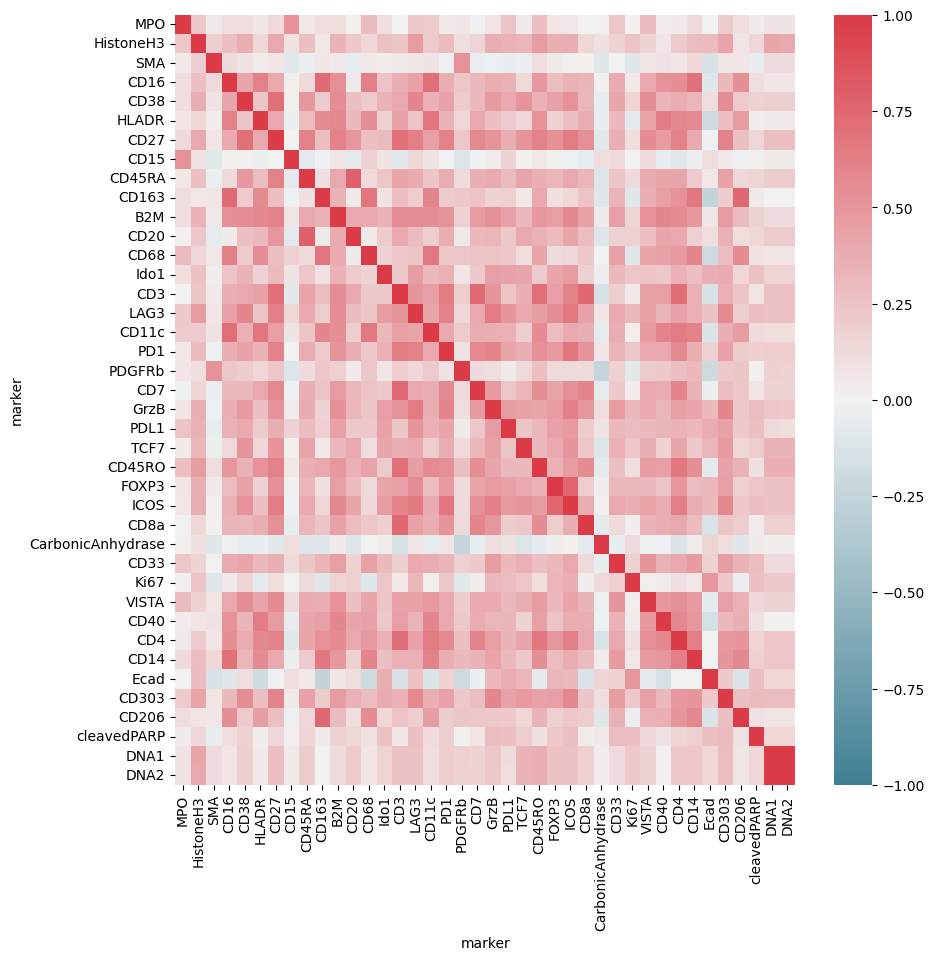

In [214]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr.columns.values,
            yticklabels=markers_corr.columns.values,
            ax=ax)
plt.savefig(os.path.join(PLOTS_DIR, 'markers_correlation.png'))

#### Let us take a look at the subset of correlation matrix:

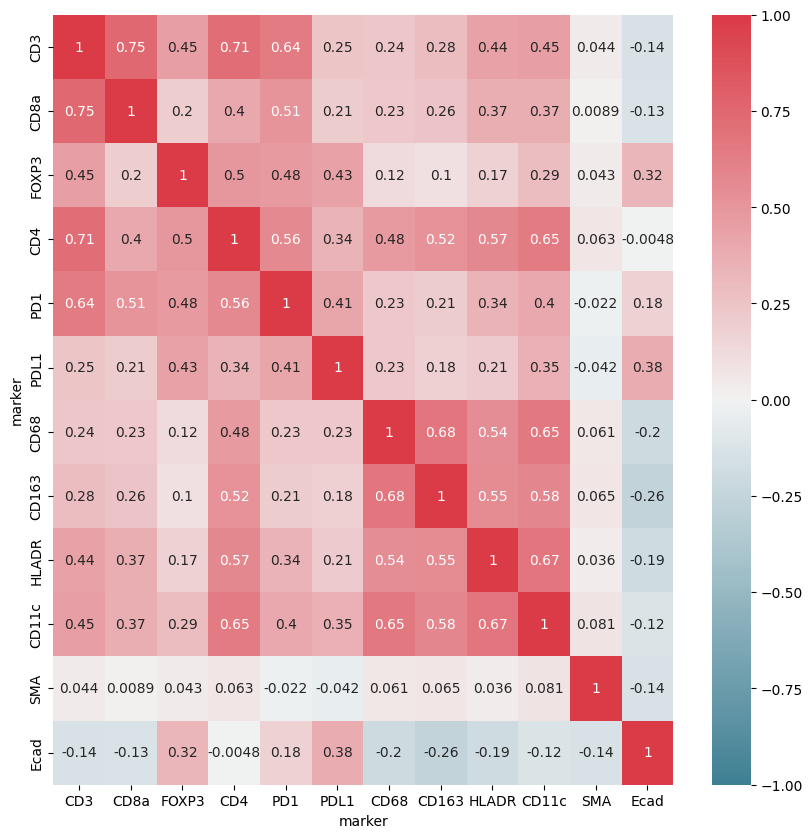

In [215]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(markers_corr_subset,
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            vmin=-1.0, vmax=1.0,
            xticklabels=markers_corr_subset.columns.values,
            yticklabels=markers_corr_subset.columns.values,
            ax=ax,
			annot=True)
plt.savefig(os.path.join(PLOTS_DIR, 'markers_correlation_subset.png'))

From those correlation coefficients we may infere some biological and clinical insights:

1. CD3 and CD8a, CD3 and CD4: These correlations make sense as both CD8a and CD4 are T cell markers, and CD3 is a component of the T cell receptor complex.
2. CD3 and PD1: PD1 is expressed on activated T cells, so a high correlation with CD3 indicates the presence of activated T cells expressing PD1, which might indicate ongoing immune responses within the tumor.

3. CD68 and CD163, CD68 and CD11c, HLADR and CD11c: These correlations suggest interactions between different subsets of immune cells, such as macrophages (CD68), M2-like macrophages (CD163), and dendritic cells (CD11c and HLADR). High correlations between these markers might indicate a complex immune landscape within the tumor, with diverse immune cell populations interacting with each other.

4. FOXP3 and CD4: FOXP3 is a marker of regulatory T cells (Tregs), which can suppress CD4+ helper T cell responses. A negative correlation between FOXP3 and CD4 might suggest an imbalance in the ratio of Tregs to helper T cells, potentially indicating immune suppression within the tumor microenvironment.


We aimed to examine the neighboring cell types of a specific cell type. To achieve this, we conducted KNN analysis and now offer the percentages of cell types as nearest neighbors. Unfortunately, as you could see in the plot above, certain cell types are substantially more prevalent in our dataset, rendering the results insignificant.

In [192]:
indices, neighbors, all_data = get_knn_of_cell_types(all_data, k=5)

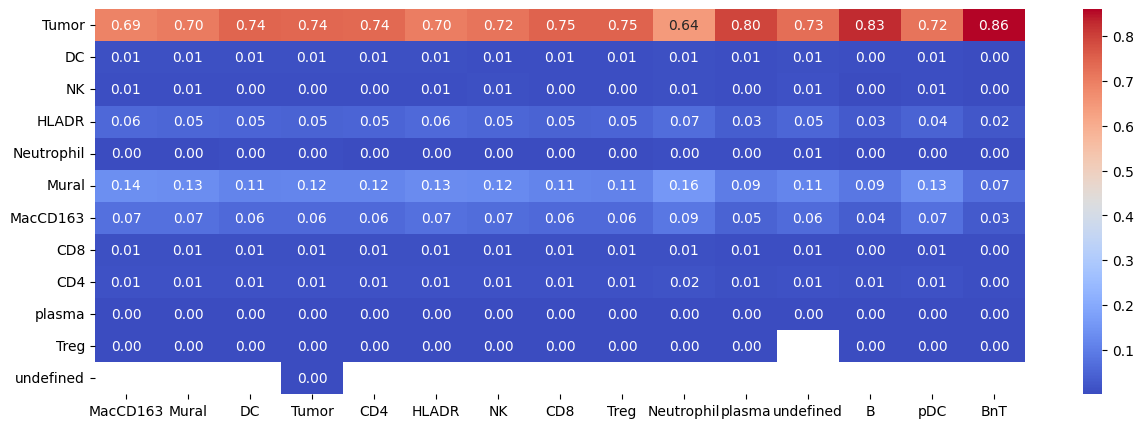

In [216]:
neighbors_cell_type_distribution = get_neighbors_cell_types_distribution(all_data, 'neighbors_cell_types.png')

Below, you can see example examined fragments of tissues, which show why tumor cells obtained such high percentages in the analysis.

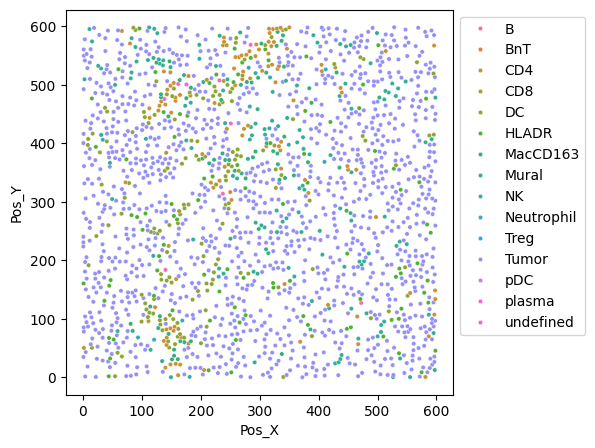

In [197]:
subdf = all_data[all_data['sample_id'] == all_data['sample_id'].unique().tolist()[3]]
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(subdf, x='Pos_X', y='Pos_Y', hue='celltypes', s=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

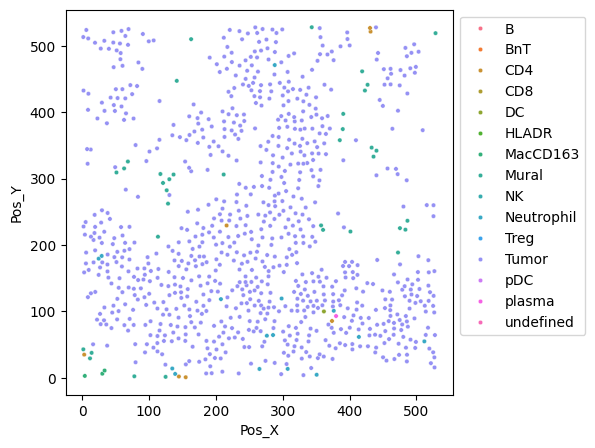

In [198]:
subdf = all_data[all_data['sample_id'] == all_data['sample_id'].unique().tolist()[2]]
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(subdf, x='Pos_X', y='Pos_Y', hue='celltypes', s=10)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()